In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ica_benchmark.sample.ica import sample_ica_data, sample_iva_data
from ica_benchmark.processing import whitening_multivar_matrix, whitening_multivar
from tqdm import tqdm
%matplotlib inline

In [2]:

K = 4
M = 40
N = 10_000

X = list()
S = list()
A = list()
W_opt = list()

def sample_iva_data(K, M, N, seed=42):
    # K number of datasets
    # M number of SVC (electrodes)
    # N number of samples
    # Sample data as in Anderson 2012 (Joint Blind Source Separation With Multivariate Gaussian Model: Algorithms and Performance Analysis)
    np.random.seed(seed)

    X, S, A = list(), list(), list()
    SCVs = list()
    for m in range (M):
        cov = np.random.normal(size=(K, K))
        cov = cov @ cov.T
        SCV = np.random.multivariate_normal(np.zeros(K), cov, size=N).T # K, N
        SCVs.append(SCV)
    S = np.stack(SCVs).transpose(1, 0, 2)
    assert S.shape == (K, M, N)        
        
    A = np.random.normal(0, 1, size=(K, M, M))
    X = np.stack([a @ s for a, s in zip(A, S)])
    assert np.all((A[0] @ S[0]) == X[0])
    return X, S, A



X, S, A = sample_iva_data(K, M, N)
# [
#     (X.append(x), S.append(s), A.append(a))
#     for (x, s, a)
#     in [
#         sample_ica_data(N, M, k)
#         for k in range(K)
#     ]
# ]
# X = np.stack(X)
# S = np.stack(S)
# A = np.stack(A)


W_opt = np.stack([np.linalg.inv(w) for w in A])
B = np.stack([whitening_multivar_matrix(x) for x in X])
Z = np.stack([b @ x for b, x in zip(B, X)])


In [3]:
# s_n_k
# g_n_k

N = 25000
M = 2
K = 3

s_1_1 = np.random.rand(N) * 2 - 1
s_2_1 = np.random.rand(N) * 2 - 1

g_1_2 = [-.3, -0.07, .2, -.021, 0.01]
g_2_2 = [-.1, 0.02, .25]
g_1_3 = [-.1, 0.02, .25]
g_2_3 = [.022, 0.4, -.09]

s_1_2 = np.convolve(s_1_1, g_1_2, mode="same")
s_2_2 = np.convolve(s_2_1, g_2_2, mode="same")
s_1_3 = np.convolve(s_1_1, g_1_3, mode="same")
s_2_3 = np.convolve(s_2_1, g_2_3, mode="same")

SCV_1 = np.stack([s_1_1, s_1_2, s_1_3])
SCV_2 = np.stack([s_2_1, s_2_2, s_2_3])
S = np.stack([SCV_1, SCV_2]).transpose(1, 0, 2)

A = np.stack(
    [
        [
            [.65, .23],
            [.35, .76]
        ],
        [
            [.8, -.53],
            [.14, -.63]
        ],
        [
            [.83, -.79],
            [.15, -.24]
        ]
    ]
)
X = A @ S
W_opt = np.stack([np.linalg.inv(w) for w in A])
# X = np.stack([whitening_multivar(x) for x in X])
X.std(2)

array([[0.40000663, 0.48341985],
       [0.1890839 , 0.10245325],
       [0.22857604, 0.06164625]])

In [17]:
def IVA_GV(Z, lr=1e-2, epochs=100, A=None, sanity_check=False):
    """Run IVA wiith multivariate Gaussian model with Vector Gradient descent.
    
    Z is the input array and is shaped K, M, N where
        K is the number of datasets
        M is the number of sources and observations
        N in the number of time samples
        
    W is the array with the weights and is shaped K, M, M (one M,M matrix per dataset)
    
    Based on Joint Blind Source Separation With Multivariate Gaussian Model: Algorithms and Performance Analysis
    
    """
    
    K, M, N = Z.shape
    grad_norm_history = np.empty((K, M, epochs))
    ISI_history = np.empty(epochs)
    ISR_history = np.empty(epochs)
    W = np.stack([np.eye(M) for _ in range(K)])
    m = 0
    # Epochs = iterations of gradient descent
    for i in tqdm(range(epochs)):
        
        # Y is the estimated sources at this iteration
        Y = np.stack([w @ z for w, z in zip(W, Z)]) # K, M, N
        Y = W @ Z # K, M, N
        
        # H contains the h_n^k vectors (h_n^k is indexed at H[k, n], with shape (M,1))
        # H is shaped K, M, M, 1
        H = np.stack([recursive_h(W[k], sanity_check=sanity_check) for k in range(K)]) # K x M x M x 1

        # Sigma inv is the inverse of the estimated SCV covariance matrix
        # Here on sigma is calculated for each SCV (sigma_inv[n] is sigma^-1 for the n-th SCV)
        sigma_inv = np.empty((M, K, K))
        for n in range(M):
#             sigma_inv[n] = np.linalg.inv(Y[:, n] @ Y[:, n].T / N)
            sigma_inv[n] = np.linalg.inv(np.cov(Y[:, n]))
        # Weight matrices update loops
        ## Iterate every dataset 
        for k in range(K):
            e = np.zeros((K, 1))
            e[k] = 1
            ## Iterate every row of the W_k
            for n in range(M):
                
                # Calculation of equation 18 in Anderson 2012
                E_xk_yn = Z[k] @ Y[:, n].T / N
                grad = E_xk_yn @ sigma_inv[n] @ e # [0, 0, 0, 1, 0]
                grad -= H[k, n] / (H[k, n].T @ W[k, n]) #, H = K, M, M, 1
                grad = grad.flatten()
#                 grad = grad / norm(grad)
                
#                 if norm(grad, 2) > 30:
#                     print("EXIT")
#                     return W
                # Apply the gradient
                w_n_new = W[k, n] - lr * (grad / norm(grad, 2))
                # Normalize the row
                w_n_new = w_n_new / norm(w_n_new, 2)
                
                grad_norm_history[k, n, i] = norm(grad, 2)
                
                # Substitute the new row
                W[k, n] = w_n_new
        
        if A is not None:
            ISI_history[i] = ISI(W, A)
            ISR_history[i] = ISR(W, A)
    print(ISI(W, A))
        
    return W, grad_norm_history, ISI_history, ISR_history
# a = IVA_GV(X, A=A, epochs=300, lr=.01)


In [441]:
I = np.stack([np.eye(M) for _ in range(K)])
# Y = a @ X
# Y = I @ X

sigma_inv = np.empty((M, K, K))
for n in range(M):
    sigma_inv[n] = np.linalg.inv(np.cov(Y[:, n]))

E_xk_yn = X[k] @ Y[:, n].T / N

# a, np.cov(Y[:, 1]), np.linalg.inv(np.cov(Y[:, 1]))
# sigma_inv[n]
E_xk_yn

array([[ 4.58345782e-04, -8.39422707e-03, -1.39127088e-05],
       [ 1.34170840e-04, -1.64048754e-03, -6.24379899e-05]])

In [444]:
X[k] @ X[k].T @ I[:, n]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

In [ ]:
# Y.var(2)
# plt.plot(Y[2, 1])
X.var(2)

100%|████████████████████████████████████████| 300/300 [00:02<00:00, 108.36it/s]


0.012351269798854592


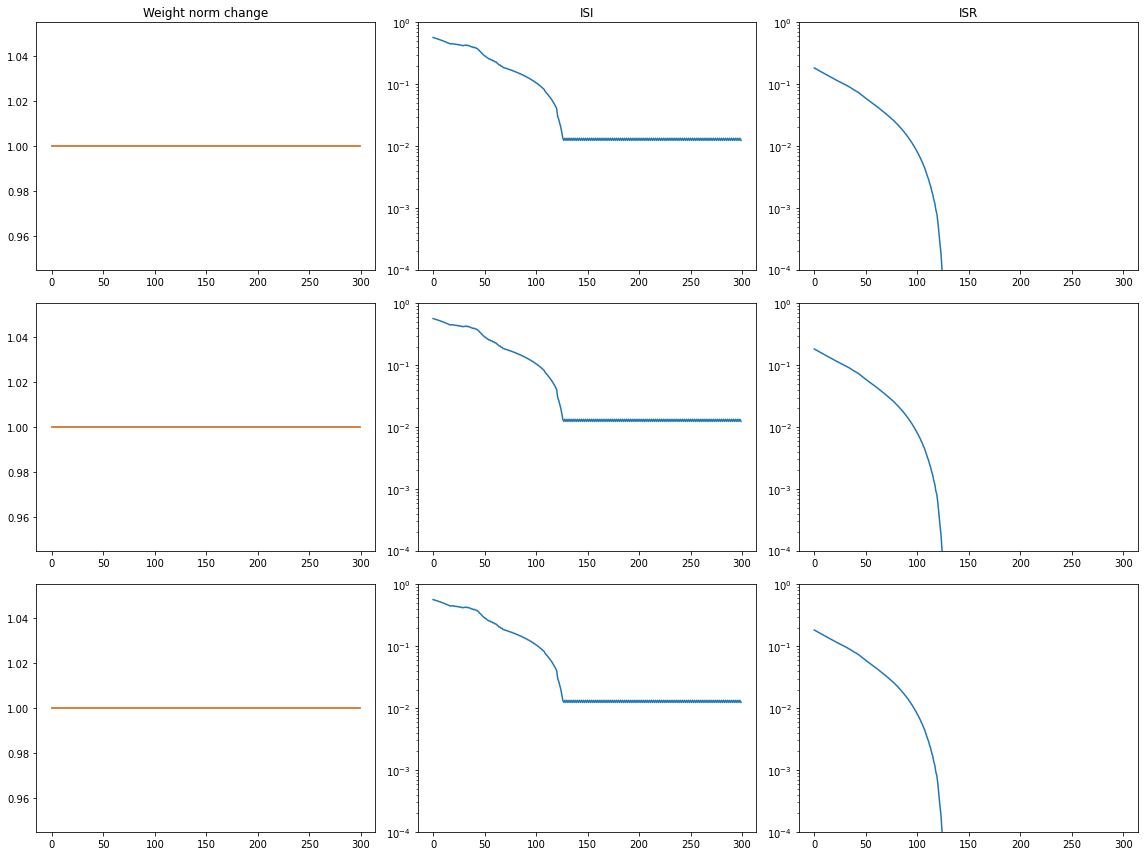

In [434]:

trials = 1
epochs = 300
delta_history = np.zeros((trials, K, M, epochs))
ISI_history = np.zeros((trials, epochs))
ISR_history = np.zeros((trials, epochs))
for trial in range(trials):
    W_, delta_history_, ISI_history_, ISR_history_ = IVA_GV(X, A=A, epochs=epochs, lr=.01)
    delta_history[trial] += delta_history_
    ISI_history[trial] += ISI_history_
    ISR_history[trial] += ISR_history_
    
fig, axes = plt.subplots(K, 3, figsize=(16, 4 * K))

for k in range(K):
    values = (delta_history.mean(0)[k].T, ISI_history.mean(0), ISR_history.mean(0))
    for col in range(3):
        axes[k, col].plot(values[col])
        if col != 0:
            axes[k, col].set_ylim((1e-4, 1))
            axes[k, col].set_yscale("log")
        

axes[0, 0].set_title("Weight norm change")
axes[0, 1].set_title("ISI")
axes[0, 2].set_title("ISR")

plt.tight_layout()

In [435]:
W_ @ A

array([[[ 5.11679280e-01, -1.36542257e-02],
        [-4.46027523e-03,  5.56704405e-01]],

       [[ 5.21707732e-01,  4.58433341e-04],
        [-5.47773080e-03, -5.24941952e-01]],

       [[ 9.43091129e-02,  3.38148832e-03],
        [-1.01293841e-03, -9.46940376e-02]]])

In [279]:
W_opt @ A

array([[[ 1.00000000e+00,  8.38775509e-17],
        [ 3.17091510e-17,  1.00000000e+00]],

       [[ 1.00000000e+00, -1.52175465e-16],
        [ 5.29177033e-17,  1.00000000e+00]],

       [[ 1.00000000e+00, -1.93528245e-16],
        [ 1.26843324e-17,  1.00000000e+00]]])

In [263]:
for k in range(K):
    for m in range(M):
        sir = 10 * np.log10((S[k, m]**2).mean() / ((S[k, m] - Y[k, m]) ** 2).mean())
        print(k, m, sir)

0 0 6.401411176976119
0 1 7.135102545856322
1 0 6.368076257210319
1 1 -3.686000615425466
2 0 0.8985148311316964
2 1 -0.7950068276395497


In [264]:
S[k, m]

array([-0.08178599, -0.29196605,  0.09315687, ...,  0.02740434,
        0.39195104, -0.41419731])

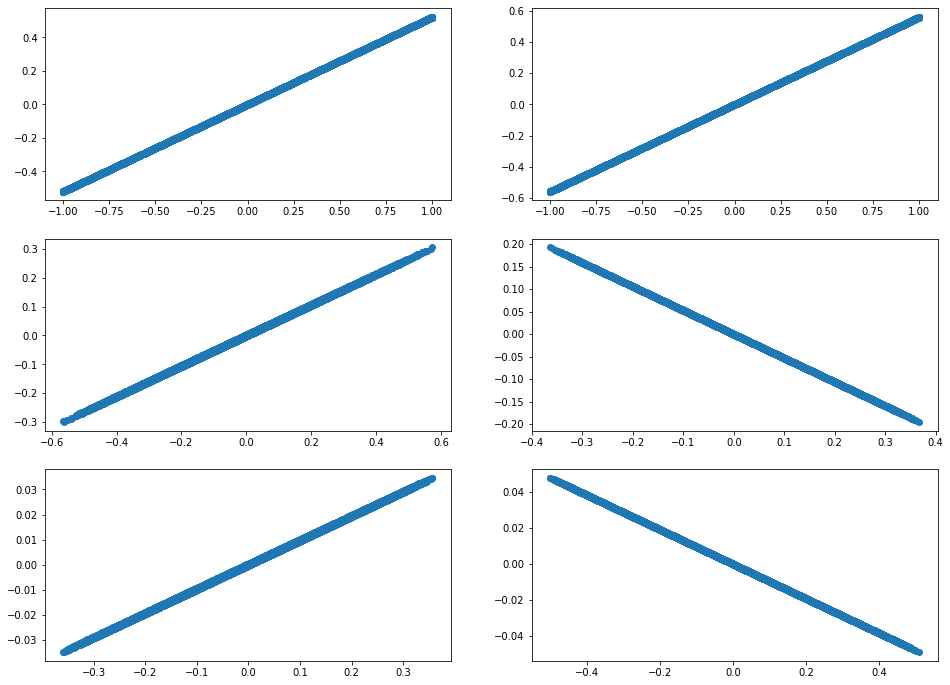

In [281]:
Y = W_ @ X


fig, axes = plt.subplots(K, M, figsize=(16, 4 * K))

for k in range(K):
    for m in range(M):
        axes[k, m].scatter(S[k, m], Y[k, m])


In [82]:
np.cov(X[0])
n = 2
np.linalg.inv(X[n] @ X[n].T / N)
np.linalg.inv(np.cov(X[n]))


array([[  428.51302119, -1550.09899358],
       [-1550.09899358,  5871.76584681]])

In [105]:
a = np.random.rand(3, 2, 2)
a @ a

array([[[1.11849212, 1.17327816],
        [1.09250894, 1.16517311]],

       [[0.94998554, 0.48614106],
        [0.62940303, 0.71963929]],

       [[0.60191495, 0.1050389 ],
        [0.48788056, 0.09822271]]])

In [107]:
w_ = ws[-1]
y = np.stack([w @ x for w, x in zip(w_, X)])
# for yy in y:
#     a = yy @ yy.T / N
#     print(a)
#     print(np.linalg.inv(a))
#     print()
np.all(y == (w_ @ X))

True

In [48]:
b = ws[-1][2] @ X[-1]
b @ b.T

array([[  30.53857005, -191.25585395],
       [-191.25585395, 1366.69391467]])

In [ ]:

trials = 1
epochs = 500
delta_history = np.zeros((trials, K, M, epochs))
ISI_history = np.zeros((trials, epochs))
ISR_history = np.zeros((trials, epochs))
for trial in range(trials):
    W_, delta_history_, ISI_history_, ISR_history_ = IVA_GV(X, A=A, epochs=epochs, lr=.1)
    delta_history[trial] += delta_history_
    ISI_history[trial] += ISI_history_
    ISR_history[trial] += ISR_history_
    
fig, axes = plt.subplots(K, 3, figsize=(16, 4 * K))

for k in range(K):
    values = (delta_history.mean(0)[k].T, ISI_history.mean(0), ISR_history.mean(0))
    for col in range(3):
        axes[k, col].plot(values[col])
        if col != 0:
            axes[k, col].set_ylim((1e-4, 1))
            axes[k, col].set_yscale("log")
        

axes[0, 0].set_title("Weight norm change")
axes[0, 1].set_title("ISI")
axes[0, 2].set_title("ISR")

plt.tight_layout()

In [154]:
a = np.array(
[[ 0.09606832, -0.00173065,  0.00843154],
 [-0.00173065,  0.00701538,  0.00037268],
 [ 0.00843154,  0.00037268,  0.00079403]]
)
np.linalg.inv(a)

array([[  553.44024548,   460.19938662, -6092.79331355],
       [  460.19938662,   528.85624652, -5134.92397295],
       [-6092.79331355, -5134.92397295, 68366.82997016]])

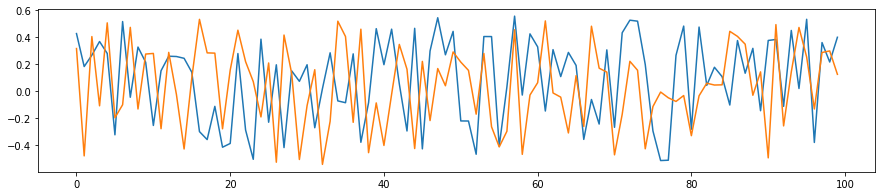

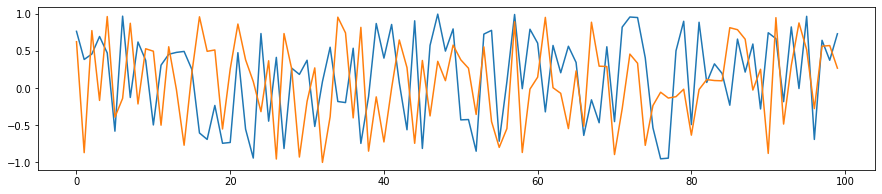

In [144]:
# from scipy.stats 
Y = np.stack([w @ x for w, x in zip(W_, X)])

plt.figure(figsize=(15, 3))
plt.plot(Y[0].T[:100])
plt.figure(figsize=(15, 3))
plt.plot(S[0].T[:100])
# Y.shape

In [112]:
W_opt

array([[[  1.83796856,  -0.55622733],
        [ -0.84643289,   1.5719468 ]],

       [[  1.46579805,  -1.23313169],
        [  0.3257329 ,  -1.86133085]],

       [[  2.9739777 ,  -9.78934325],
        [  1.85873606, -10.2850062 ]]])

In [113]:
for w, a in zip(W_, A):
    g = w @ a
    print(g / g.max())
    print()

[[ 0.95795208  0.00885168]
 [-0.0312547   1.        ]]

[[ 1.         -0.03720372]
 [-0.02622464 -0.9649808 ]]

[[-0.1885515   0.30939035]
 [ 1.         -1.03130316]]



Text(0.5, 1.0, 'Est SCV from Z 0')

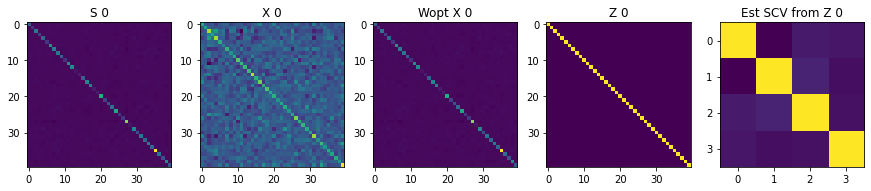

In [2]:
s_0 = S[0]
x_0 = X[0]
z_0 = Z[0]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))
ax1.imshow(s_0 @ s_0.T / N)
ax1.set_title("S 0")
ax2.imshow(x_0 @ x_0.T / N)
ax2.set_title("X 0")
ax3.imshow(
    (W_opt[0] @ x_0) @ (W_opt[0] @ x_0).T / N
)
ax3.set_title("Wopt X 0")
ax4.imshow(
    (whitening_multivar_matrix(x_0) @ x_0) @ (whitening_multivar_matrix(x_0) @ x_0).T / N
)
ax4.set_title("Z 0")
ax5.imshow(Z[:, 0] @ Z[:, 0].T / N)
ax5.set_title("Est SCV from Z 0")



In [3]:
Z[:, 0] @ Z[:, 0].T / N

array([[ 1.        , -0.01544749,  0.05867937,  0.04738889],
       [-0.01544749,  1.        ,  0.08308821,  0.02378244],
       [ 0.05867937,  0.08308821,  1.        ,  0.03107008],
       [ 0.04738889,  0.02378244,  0.03107008,  1.        ]])

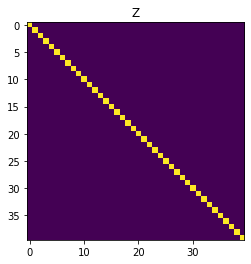

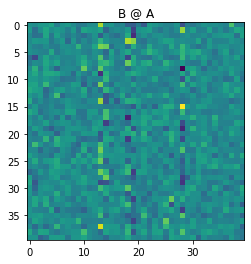

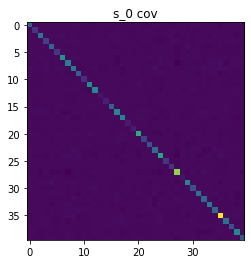

In [4]:
x_0 = X[0]
B = whitening_multivar_matrix(x_0)

c = B @ x_0
plt.imshow(c @ c.T)
plt.title("Z")
plt.show()

plt.imshow(B @ A[0])
plt.title("B @ A")
plt.show()


plt.imshow(s_0 @ s_0.T)
plt.title("s_0 cov")
plt.show()

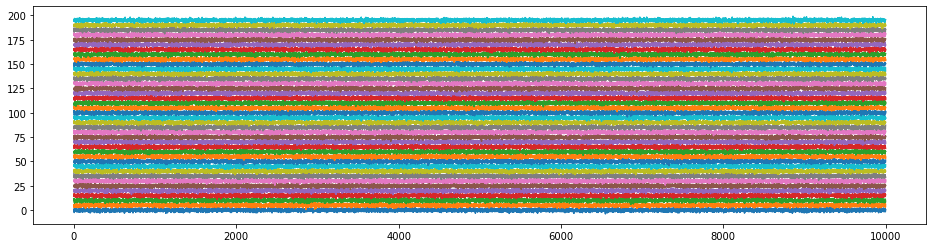

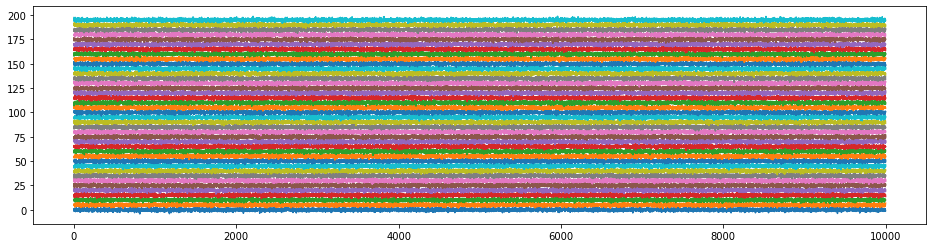

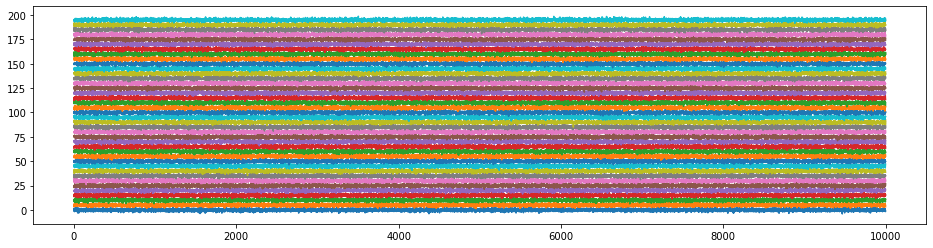

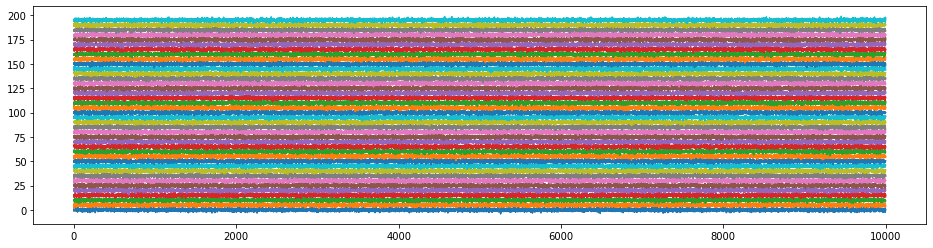

In [5]:
for z_k in Z:
    plt.figure(figsize=(16, 4))
    plt.plot(z_k.T + np.arange(M) * 5)

In [6]:
from scipy.linalg import toeplitz
from itertools import product


In [5]:
def init_W(K, M):
    W = np.zeros((K, M, M))
    W[:, np.arange(M), np.arange(M)] = 1
    W += np.random.rand(*W.shape) / 10
    return W
    

In [472]:
from numpy.linalg import norm

def angle(a, b):
    return a.dot(b) / (norm(a) * norm(b))

def get_random_not_orthogonal(x):
    x = x.flatten()
    tries = 0
    while True:
        r = np.random.rand(len(x)).flatten()
        a = angle(r, x)
        if np.abs(a) <= 1e-4:
            tries += 1
            continue
        if tries >= 10:
            raise Exception("FAIL", x, r, a)
#         if a <= 1e-4:
#             raise Exception("FAIL", x, r, a)
        return r
    
def recursive_h(W, sanity_check=False):
    # Adali 2010
    W = W.copy()
    M, M = W.shape
    Q = list()
    Q_inv = list()
    h = list()
    c = list()
    
    # c_n calculations
    for n in range(M - 1):
        W_n = W[np.arange(M) != n] # Size M - 1

        c_n = np.array(
            [
                (W[n] - W[n + 1]).T @ W[i] if i != n else (norm(W[n]) ** 2 - norm(W[n + 1]) ** 2) / 2
                for i
                in range(M)
                if i != n + 1
            ]
        ).reshape(-1, 1)
#         nn = n + 1
#         c_n_str = [
#             f"(W_{nn} - W_{nn + 1}).T @ W_{i+1}" if i != n else f"(norm(W_{nn}) ** 2 - norm(W_{nn + 1}) ** 2) / 2"
#             for i
#             in range(M)
#             if i != n + 1
#         ]
#         print(f"N={M}, n={nn}, ", c_n.shape)
#         print("\n".join(c_n_str), end="\n\n")
        c.append(c_n)

    # First Q
    W_1 = W[np.arange(M) != 0]
    Q_1 = W_1 @ W_1.T
    Q_inv.append(np.linalg.inv(Q_1))
    # Q_{n+1} calculation
    for n in range(M - 1):
        # Calculate Q_{n+1} from Q_{n}, starting from precalculated Q_1
        e_n = np.zeros((M - 1, 1))
        c_n = c[n]
        # e has the (n-1)th value equal to 1 because we are calculating Q_n instead of Q_{n+1}
        e_n[n] = 1
        Q_n_inv = Q_inv[n]
        Qn_1_inv = Q_n_inv - Q_n_inv @ c_n @ e_n.T @ Q_n_inv / ( 1 + e_n.T @ Q_n_inv @ c_n)
        Qn_1_inv = Qn_1_inv - Qn_1_inv @ e_n @ c_n.T @ Qn_1_inv / ( 1 + c_n.T @ Qn_1_inv @ e_n)
        # Append Q_n+1 to Q, until M - 1 (n + 1= M)
        Q_inv.append(Qn_1_inv)

    
    for n in range(M):
        W_n = W[np.arange(M) != n]
        r = get_random_not_orthogonal(W[n]).reshape(-1, 1)
        P_n = np.eye(M) - W_n.T @ Q_inv[n] @ W_n
        
        h_n = P_n @ r
        h_n /= norm(h_n, 2)
        if sanity_check:
            sanity = W[np.arange(M) != n] @ h_n
            assert np.allclose(sanity, 0, atol=1e-5), f"For h_{n}: " + str(sanity)
        h.append(h_n)
    return np.stack(h)

recursive_h(W[0]);

In [473]:
def get_hn(W, n, sanity_check=False):
    M, _ = W.shape
    W_n = W[np.arange(M) != n]
    Q_inv = np.linalg.inv(W_n @ W_n.T)
    r = get_random_not_orthogonal(W[n]).reshape(-1, 1)
    P_n = np.eye(M) - W_n.T @ Q_inv @ W_n

    h_n = P_n @ r
    h_n /= norm(h_n, 2)
    if sanity_check:
        assert np.allclose(W_n @ h_n, 0, atol=1e-5)
    return h_n

def non_recursive_h(W, sanity_check=False):
    # Adali 2010
    W = W.copy()
    M, M = W.shape
    h = list()
    
    for n in range(M):
        h_n = get_hn(W, n)
        if sanity_check:
            sanity = W[np.arange(M) != n] @ h_n
            assert np.allclose(sanity, 0, atol=1e-5), f"For h_{n}: " + str(sanity)
        h.append(h_n)
            
    return np.stack(h)
non_recursive_h(np.random.rand(50, 50), sanity_check=True);

In [474]:
from timeit import timeit

def get_c_n(W, n, i):
    M, _ = W.shape
    assert i != n + 1
    print(n, W.shape)
    return (W[n] - W[n + 1]).T @ W[i] if i != n else (norm(W[n]) ** 2 - norm(W[n + 1]) ** 2) / 2
    
def incremental_h(W, c=None, Q_inv=None, n_list=None, sanity_check=False):
    # Adali 2010
    W = W.copy()
    M, M = W.shape
    Q = list()
    h = list()

    if (n_list is None) or (c is None) or (Q_inv is None):
        n_list = range(M - 1)
        c = list()
        Q_inv = list()
    
    # c_n calculations
    for n in n_list:
        c_n = np.array(
            [
                (W[n] - W[n + 1]).T @ W[i] if i != n else (norm(W[n]) ** 2 - norm(W[n + 1]) ** 2) / 2
                for i
                in range(M)
                if i != n + 1
            ]
        ).reshape(-1, 1)
#         nn = n + 1
#         c_n_str = [
#             f"(W_{nn} - W_{nn + 1}).T @ W_{i+1}" if i != n else f"(norm(W_{nn}) ** 2 - norm(W_{nn + 1}) ** 2) / 2"
#             for i
#             in range(M)
#             if i != n + 1
#         ]
#         print(f"N={M}, n={nn}, ", c_n.shape)
#         print("\n".join(c_n_str), end="\n\n")
        if len(c) > n:
            c[n] = c_n
        else:
            c.append(c_n)

    # First Q, if the passed Q_inv was None calculate Q_1 ^ -1
    if len(Q_inv) == 0:
        W_1 = W[np.arange(M) != 0]
        Q_1 = W_1 @ W_1.T
        Q_inv.append(np.linalg.inv(Q_1))
    # Q_{n+1} calculation
    for n in n_list:
        # Calculate Q_{n+1} from Q_{n}, starting from precalculated Q_1
        e_n = np.zeros((M - 1, 1))
        c_n = c[n]
        # e has the (n-1)th value equal to 1 because we are calculating Q_n instead of Q_{n+1}
        e_n[n] = 1
        Q_n_inv = Q_inv[n]
        Qn_1_inv = Q_n_inv - Q_n_inv @ c_n @ e_n.T @ Q_n_inv / ( 1 + e_n.T @ Q_n_inv @ c_n)
        Qn_1_inv = Qn_1_inv - Qn_1_inv @ e_n @ c_n.T @ Qn_1_inv / ( 1 + c_n.T @ Qn_1_inv @ e_n)
        # Append Q_n+1 to Q, until M - 1 (n + 1= M)
        if n < len(Q_inv) - 1:
            Q_inv[n + 1] = Qn_1_inv
        else:
            Q_inv.append(Qn_1_inv)

    
    for n in range(M):
        W_n = W[np.arange(M) != n]
        r = get_random_not_orthogonal(W[n]).reshape(-1, 1)
        P_n = np.eye(M) - W_n.T @ Q_inv[n] @ W_n
        
        h_n = P_n @ r
        h_n /= norm(h_n, 2)
        if sanity_check:
            sanity = W[np.arange(M) != n] @ h_n
            assert np.allclose(sanity, 0, atol=1e-5), f"For h_{n}: " + str(sanity)
        h.append(h_n)
            
    return np.stack(h), c, Q_inv

H, c_, Q_inv_ = incremental_h(W[0], sanity_check=True)


# H, c_, Q_inv_ = incremental_h(W, c_, Q_inv_, n_list=range(10 - 1), sanity_check=True)


# t_all = timeit('incremental_h(W, sanity_check=True)', number=100, globals=globals())
# t_1 = timeit('incremental_h(W, c_, Q_inv_, n_list=range(10 - 1), sanity_check=True)', number=100, globals=globals())
# t_all, t_1

In [475]:

W = np.random.rand(10, 10)
H_r = recursive_h(W, True);
H_nr = non_recursive_h(W, True);
H_i, c_, Q_inv_ = incremental_h(W, sanity_check=True)
H_i2, _, _ = incremental_h(W, c_, Q_inv_, n_list=[3, 5], sanity_check=True)

for i in range(10):
    sanity_r = W[np.arange(10) != i] @ H_r[i]
    sanity_nr = W[np.arange(10) != i] @ H_nr[i]
    sanity_i = W[np.arange(10) != i] @ H_i[i]
    sanity_i2 = W[np.arange(10) != i] @ H_i2[i]
    
    assert np.allclose(sanity_r, 0, atol=1e-8), sanity_r
    assert np.allclose(sanity_nr, 0, atol=1e-8), sanity_nr
    assert np.allclose(sanity_i, 0, atol=1e-8), sanity_i
    assert np.allclose(sanity_i2, 0, atol=1e-8), sanity_i2
    

0,10,20,30,40,50,60,70,80,90,100,

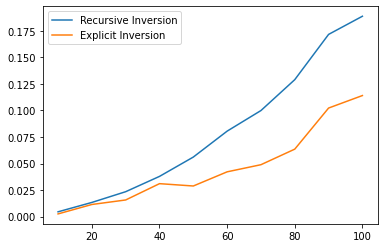

In [476]:
from time import time

def run_r(M):
    W = np.random.rand(M, M)
    H = recursive_h(W)

def run_nr(M):
    W = np.random.rand(M, M)
    H = non_recursive_h(W)

trials = 10

M_arr = np.arange(0, 100 + 1, 10)
r_time = list()
nr_time = list()
M_list = list()
for m in M_arr:
    print(m, end=",")
    if m == 0:
        continue
    M_list.append(m)
    m_r_time = 0
    m_nr_time = 0
    for trial in range(trials):
        start = time()
        run_r(m)
        m_r_time += (time() - start) / trials
        
        start = time()
        run_nr(m)
        m_nr_time += (time() - start) / trials
    r_time.append(m_r_time)
    nr_time.append(m_nr_time)
        
plt.plot(M_list, r_time, label="Recursive Inversion")
plt.plot(M_list, nr_time, label="Explicit Inversion")
plt.legend()

In [477]:
# # All must be zero

# for k in range(K):
#     for m in range(M):
# #         print(
# # #             f"k={k},m={m}", angle(H[k, m].flatten(), W[k, np.arange(M) != m])
# #             f"k={k},m={m}\n", W[k, np.arange(M) != m] @ H[k, m]
# #         )
#         assert np.allclose(W[k, np.arange(M) != m] @ H[k, m], 0, atol=1e-5)
    

In [478]:
def ISI(W, A):
    # https://github.com/trendscenter/gift/blob/ca71b3ab852423f1c2dc118017917a231265fc84/GroupICATv4.0c/icatb/icatb_analysis_functions/icatb_algorithms/icatb_iva_laplace.m
    assert W.shape == A.shape
    K, M, _ = W.shape
    G = np.stack([W[k] @ A[k] for k in range(K)])
    G = np.abs(G).sum(axis=0)
    isi = 1 / (2 * M * (M - 1))
    score = - 2 * M
    score += (G / G.max(axis=1, keepdims=True)).sum()
    score += (G / G.max(axis=0, keepdims=True)).sum()

    return isi * score

    
a = """
0.948709   0.926739   0.130089   0.770445
0.930650   0.399674   0.200565   0.144566
0.078480   0.045465   0.942084   0.608882
0.954525   0.377033   0.036410   0.163378
"""
b = """
0.075914   0.622760   0.640964   0.035257
0.294842   0.159619   0.083161   0.614882
0.013225   0.363917   0.856707   0.198607
0.848886   0.556646   0.397540   0.246305
"""
def str_parse(x):
    return np.array([list(map(float, a.split("   "))) for a in x.split("\n") if a])
isi = ISI(
    str_parse(a).reshape(1, 4, 4),
    str_parse(b).reshape(1, 4, 4)
)
np.isclose(isi, 0.59194, 1e-5), isi

(True, 0.5919361163708312)

In [479]:
def ISR(W, A):
    assert W.shape == A.shape
    K, M, _ = W.shape
    G = np.stack([w @ a for w, a in zip(W, A)])
    G = np.stack([g - np.diag(g.diagonal()) for g in G])
    
    score = np.power(G, 2).sum() / (K * M * (M - 1))
    return score

ISR(np.stack([np.linalg.inv(a) for a in A]), A), ISR(np.random.rand(K, M, M), A)

(1.273321484826228e-28, 12.727935445813253)

5.60235618580079e-15

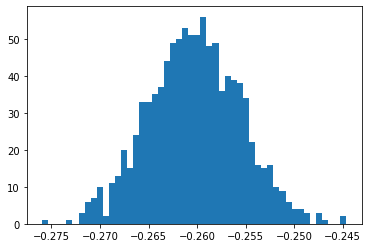

In [480]:
plt.hist(
    [
        np.log10(
            ISI(
                np.random.rand(K, M, M),
                A,
            )
        )
        for _ in range(1000)
    ],
    bins=50
)
ISI(W_opt, A)

(1.273321484826228e-28, 0.9866876038902385, 12.958866337558632)

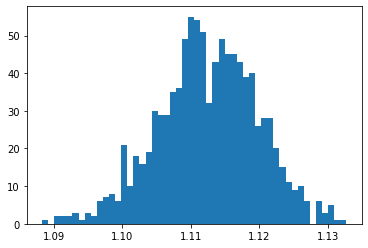

In [481]:
plt.hist(
    [
        np.log10(
            ISR(
                np.random.rand(K, M, M),
                A,
            )
        )
        for _ in range(1000)
    ],
    bins=50
)
(
    ISR(W_opt, A),
    ISR(np.stack([np.eye(M) for k in range(K)]), A),
    ISR(np.random.rand(K, M, M), A)
)

In [482]:
def phi_n(y_n):
    M, N = y_n.shape
    value = np.linalg.inv(y_n @ y_n.T / N) @ y_n
    return value.mean(axis=1)

def phi(y):
    K, M, N = y.shape
    return np.stack([phi_n(y[:, m]) for m in range(M)])

# plt.imshow(phi(Z)[0])

phi_n(Z[:, 0]).shape, phi(Z).shape

((4,), (40, 4))

In [483]:
R = X[0] @ X[0].T / N
W = np.random.normal(0, 1, size=(M, M))
Y = W @ X[0]

R

array([[116.4852286 ,  -3.25307833, -16.29148389, ...,   8.18311301,
          0.46698044,  19.65314007],
       [ -3.25307833, 104.94138636,  -1.96461196, ...,   8.65574696,
        -24.56512111,  -8.40818088],
       [-16.29148389,  -1.96461196, 208.34635226, ..., -15.54647257,
         -5.4288936 , -34.88906044],
       ...,
       [  8.18311301,   8.65574696, -15.54647257, ..., 117.43654185,
         12.25467277, -17.01665338],
       [  0.46698044, -24.56512111,  -5.4288936 , ...,  12.25467277,
         84.38422284,  -6.20295607],
       [ 19.65314007,  -8.40818088, -34.88906044, ..., -17.01665338,
         -6.20295607, 253.19994943]])

In [484]:
from tqdm import tqdm


def IVA_GV(Z, lr=1e-2, epochs=100, A=None):
    K, M, N = Z.shape
    delta_history = np.empty((K, M, epochs))
    ISI_history = np.empty(epochs)
    ISR_history = np.empty(epochs)
    W = np.stack([np.eye(M) for _ in range(K)])
    
    # Epochs = iterations of gradient descent
    for i in tqdm(range(epochs)):
        
        # Y is the estimated sources at this iterations
        Y = np.stack([W[k] @ Z[k] for k in range(K)])
        # H contains the h_n^k vectors (H[k, n])
        H = np.stack([recursive_h(W[k], sanity_check=True) for k in range(K)]) # K x M x M x 1

        # Sigma inv is the inverse of the estimated SCV covariance matrix
        sigma_inv = np.empty((M, K, K))
        for n in range(M):
            sigma_inv[n] = np.linalg.inv(Y[:, n] @ Y[:, n].T / N)
        
        # Weight matrices update loops
        ## Iterate every dataset 
        for k in range(K):
            e = np.zeros((K, 1))
            e[k] = 1

            ## Iterate every row of the W_k
            for n in range(M):
                delta = (Z[k] @ Y[:, n].T / N) @ sigma_inv[n] @ e
                delta -= H[k, n] / (H[k, n].T @ W[k, n])
                # E[x[k] @ y[n].T] @ sigma_n ^⁻1 @ ek
                delta = delta.flatten()
    #             delta = (Z[k]).mean(axis=1, keepdims=True).T

                w_n_new = W[k, n] - lr * delta
                w_n_new = w_n_new / norm(w_n_new, 2)
                delta_history[k, n, i] = norm(W[k, n] - w_n_new)
                W[k, n] = w_n_new
                
                
        if A is not None:
            ISI_history[i] = ISI(W, A)
            ISR_history[i] = ISR(W, A)

        
    return W, delta_history, ISI_history, ISR_history
IVA_GV(X, epochs=1);

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


In [485]:
from itertools import product

# Asserting that the sigma calculation strategy we do is the same as done in the paper

n = 2
k1 = 3
k2 = 4
tol = 1e-6

W = np.random.rand(K, M, M)
Y = np.stack([w @ x for w, x in zip(W, X)])

# Sigma calculation
for n, k1, k2 in product(range(M), range(K), range(K)):
    
    # Calculation strategy 1: calculate covariance matrix directly from the estimated sources Y
    sigma = Y[:, n] @ Y[:, n].T / N
    mode_1 = sigma[k1, k2]

    # Calculation strategy 2: as described in Anderson 2012
    R = X[k1] @ X[k2].T / N
    mode_2 = W[k1, n] @ R @ W[k2, n]

    assert np.abs(mode_1 - mode_2) < tol, (mode_1, mode_2, n, k1, k2)

# Expectation of E[x^k y_n^T]
for k, n in product(range(K), range(M)):
    mode_1 = X[k] @ Y[:, n].T / N
    mode_2 = np.stack(
        [
            X[k] @ X[kk].T @ W[kk, n] / N
            for kk in range(K)
        ]
    ).T
    assert np.allclose(mode_1, mode_2, atol=tol)

In [486]:
def IVA_GV(Z, lr=1e-2, epochs=100, A=None, sanity_check=False):
    """Run IVA wiith multivariate Gaussian model with Vector Gradient descent.
    
    Z is the input array and is shaped K, M, N where
        K is the number of datasets
        M is the number of sources and observations
        N in the number of time samples
        
    W is the array with the weights and is shaped K, M, M (one M,M matrix per dataset)
    
    Based on Joint Blind Source Separation With Multivariate Gaussian Model: Algorithms and Performance Analysis
    
    """
    
    K, M, N = Z.shape
    grad_norm_history = np.empty((K, M, epochs))
    ISI_history = np.empty(epochs)
    ISR_history = np.empty(epochs)
    W = np.stack([np.eye(M) for _ in range(K)])
    m = 0
    # Epochs = iterations of gradient descent
    for i in tqdm(range(epochs)):
        
        # Y is the estimated sources at this iteration
        Y = np.stack([w @ z for w, z in zip(W, Z)]) # K, M, N
        Y = W @ Z # K, M, N
        
        # H contains the h_n^k vectors (h_n^k is indexed at H[k, n], with shape (M,1))
        # H is shaped K, M, M, 1

        # Sigma inv is the inverse of the estimated SCV covariance matrix
        # Here on sigma is calculated for each SCV (sigma_inv[n] is sigma^-1 for the n-th SCV)
        sigma_inv = np.empty((M, K, K))
        for n in range(M):
#             sigma_inv[n] = np.linalg.inv(Y[:, n] @ Y[:, n].T / N)
            sigma_inv[n] = np.linalg.inv(np.cov(Y[:, n]))
        # Weight matrices update loops
        ## Iterate every dataset 
        for n in range(M):
            H = np.stack([non_recursive_h(W[k], sanity_check=sanity_check) for k in range(K)]) # K x M x M x 1
            for k in range(K):
                e = np.zeros((K, 1))
                e[k] = 1
                ## Iterate every row of the W_k
                
                # Calculation of equation 18 in Anderson 2012
                E_xk_yn = Z[k] @ Y[:, n].T / N
                grad = E_xk_yn @ sigma_inv[n] @ e # [0, 0, 0, 1, 0]
                grad -= H[k, n] / (H[k, n].T @ W[k, n]) #, H = K, M, M, 1
                grad = grad.flatten()

                # Apply the gradient
                w_n_new = W[k, n] - lr * (grad / norm(grad, 2))
                # Normalize the row
                w_n_new = w_n_new / norm(w_n_new, 2)
                
                grad_norm_history[k, n, i] = norm(grad, 2)
                
                # Substitute the new row
                W[k, n] = w_n_new
        
        if A is not None:
            ISI_history[i] = ISI(W, A)
            ISR_history[i] = ISR(W, A)
        
    return W, grad_norm_history, ISI_history, ISR_history
# a = IVA_GV(X, A=A, epochs=300, lr=.01)


In [502]:
def IVA_GV_INC(Z, lr=1e-2, epochs=100, A=None, sanity_check=False):
    """Run IVA wiith multivariate Gaussian model with Vector Gradient descent.
    
    Z is the input array and is shaped K, M, N where
        K is the number of datasets
        M is the number of sources and observations
        N in the number of time samples
        
    W is the array with the weights and is shaped K, M, M (one M,M matrix per dataset)
    
    Based on Joint Blind Source Separation With Multivariate Gaussian Model: Algorithms and Performance Analysis
    
    """
    
    K, M, N = Z.shape
    grad_norm_history = np.empty((K, M, epochs))
    ISI_history = np.empty(epochs)
    ISR_history = np.empty(epochs)
    W = np.stack([np.eye(M) for _ in range(K)])
    m = 0
    # Epochs = iterations of gradient descent
    for i in tqdm(range(epochs)):
        
        # Y is the estimated sources at this iteration
        Y = np.stack([w @ z for w, z in zip(W, Z)]) # K, M, N
        Y = W @ Z # K, M, N
        
        # H contains the h_n^k vectors (h_n^k is indexed at H[k, n], with shape (M,1))
        # H is shaped K, M, M, 1

        # Sigma inv is the inverse of the estimated SCV covariance matrix
        # Here on sigma is calculated for each SCV (sigma_inv[n] is sigma^-1 for the n-th SCV)
        sigma_inv = np.empty((M, K, K))
        for n in range(M):
#             sigma_inv[n] = np.linalg.inv(Y[:, n] @ Y[:, n].T / N)
            sigma_inv[n] = np.linalg.inv(np.cov(Y[:, n]))
        # Weight matrices update loops
        ## Iterate every dataset 
#         H = np.stack([non_recursive_h(W[k], sanity_check=sanity_check) for k in range(K)]) # K x M x M x 1
        for n in range(M):
            for k in range(K):
                e = np.zeros((K, 1))
                e[k] = 1
                ## Iterate every row of the W_k
                
                # Calculation of equation 18 in Anderson 2012
                E_xk_yn = Z[k] @ Y[:, n].T / N
                grad = E_xk_yn @ sigma_inv[n] @ e # [0, 0, 0, 1, 0]
                h_k_n = get_hn(W[k], n)
                grad -= h_k_n / (h_k_n.T @ W[k, n]) #, H = K, M, M, 1
                grad = grad.flatten()

                # Apply the gradient
                w_n_new = W[k, n] - lr * (grad / norm(grad, 2))
                # Normalize the row
                w_n_new = w_n_new / norm(w_n_new, 2)
                
                grad_norm_history[k, n, i] = norm(grad, 2)
                
                # Substitute the new row
                W[k, n] = w_n_new
                
#                 H[k, n] = get_hn(W[k], n)
        if A is not None:
            ISI_history[i] = ISI(W, A)
            ISR_history[i] = ISR(W, A)
        
    return W, grad_norm_history, ISI_history, ISR_history
# a = IVA_GV(X, A=A, epochs=300, lr=.01)
# IVA_GV(X, epochs=5);
IVA_GV_INC(X, epochs=50);


100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.79it/s]


In [ ]:
# ATUALIZAR SIGMA N DPS DE CADA ATUALIZACAO POR GRADIENTE (DENTRO DOS 2 FOR's)

In [524]:
def IVA_GV_ADAM(Z, lr=1e-2, epochs=100, A=None, sanity_check=False, b1=.9, b2=.999):
    """Run IVA wiith multivariate Gaussian model with Vector Gradient descent.
    
    Z is the input array and is shaped K, M, N where
        K is the number of datasets
        M is the number of sources and observations
        N in the number of time samples
        
    W is the array with the weights and is shaped K, M, M (one M,M matrix per dataset)
    
    Based on Joint Blind Source Separation With Multivariate Gaussian Model: Algorithms and Performance Analysis
    
    """
    
    K, M, N = Z.shape
    grad_norm_history = np.empty((K, M, epochs))
    ISI_history = np.empty(epochs)
    ISR_history = np.empty(epochs)
    W = np.stack([np.eye(M) for _ in range(K)])
    # Epochs = iterations of gradient descent
    m = np.zeros((2, K, M, M))
    v = np.zeros((2, K, M, M))

    for i in tqdm(range(epochs)):

    
        # Y is the estimated sources at this iteration
        Y = np.stack([w @ z for w, z in zip(W, Z)]) # K, M, N
        Y = W @ Z # K, M, N
        
        # H contains the h_n^k vectors (h_n^k is indexed at H[k, n], with shape (M,1))
        # H is shaped K, M, M, 1

        # Sigma inv is the inverse of the estimated SCV covariance matrix
        # Here on sigma is calculated for each SCV (sigma_inv[n] is sigma^-1 for the n-th SCV)
        sigma_inv = np.empty((M, K, K))
        for n in range(M):
#             sigma_inv[n] = np.linalg.inv(Y[:, n] @ Y[:, n].T / N)
            sigma_inv[n] = np.linalg.inv(np.cov(Y[:, n]))
        # Weight matrices update loops
        ## Iterate every dataset 
#         H = np.stack([non_recursive_h(W[k], sanity_check=sanity_check) for k in range(K)]) # K x M x M x 1
        for n in range(M):
            for k in range(K):
                e = np.zeros((K, 1))
                e[k] = 1
                ## Iterate every row of the W_k
                
                # Calculation of equation 18 in Anderson 2012
                E_xk_yn = (Z[k] @ Y[:, n].T) / N
                h_k_n = get_hn(W[k], n)

                grad = E_xk_yn @ sigma_inv[n] @ e # [0, 0, 0, 1, 0]
#                 grad = (E_xk_yn @ sigma_inv[n])[:, [k]] # [0, 0, 0, 1, 0]
                grad -= h_k_n / (h_k_n.T @ W[k, n]) #, H = K, M, M, 1
                grad = grad.flatten()
#                 grad = grad / norm(grad)
                
                m[1, k, n] = b1 * (m[0, k, n]) + (1 - b1) * grad
                v[1, k, n] = b2 * (v[0, k, n]) + (1 - b2) * grad ** 2
            
                mhat = m[1, k, n] / (1 - b1**(i + 1))
                vhat = v[1, k, n] / (1 - b2**(i + 1))
    
                # Apply the gradient
#                 w_n_new = W[k, n] - lr * (grad / norm(grad, 2))
                w_n_new  = W[k, n] - lr * mhat / (np.sqrt(vhat) + 1e-6)
                # Normalize the row
                w_n_new = w_n_new / norm(w_n_new, 2)
                
                grad_norm_history[k, n, i] = norm(mhat / (np.sqrt(vhat) + 1e-6), 2)
                
                # Substitute the new row
                W[k, n] = w_n_new
                
                m[0, k, n] = m[1, k, n]
                v[0, k, n] = v[1, k, n]

        if A is not None:
            ISI_history[i] = ISI(W, A)
            ISR_history[i] = ISR(W, A)
        
    return W, grad_norm_history, ISI_history, ISR_history
# a = IVA_GV(X, A=A, epochs=300, lr=.01)


In [ ]:
# RODADO de control shift z acima

In [525]:
# W, delta_history, ISI_history, ISR_history = IVA_GV(X, A=A, epochs=1000, lr=.01, sanity_check=False)
W, delta_history, ISI_history, ISR_history = IVA_GV_ADAM(X, A=A, epochs=2000, lr=.1, sanity_check=False, b1=.99, b2=.99)


100%|███████████████████████████████████████| 2000/2000 [11:27<00:00,  2.91it/s]


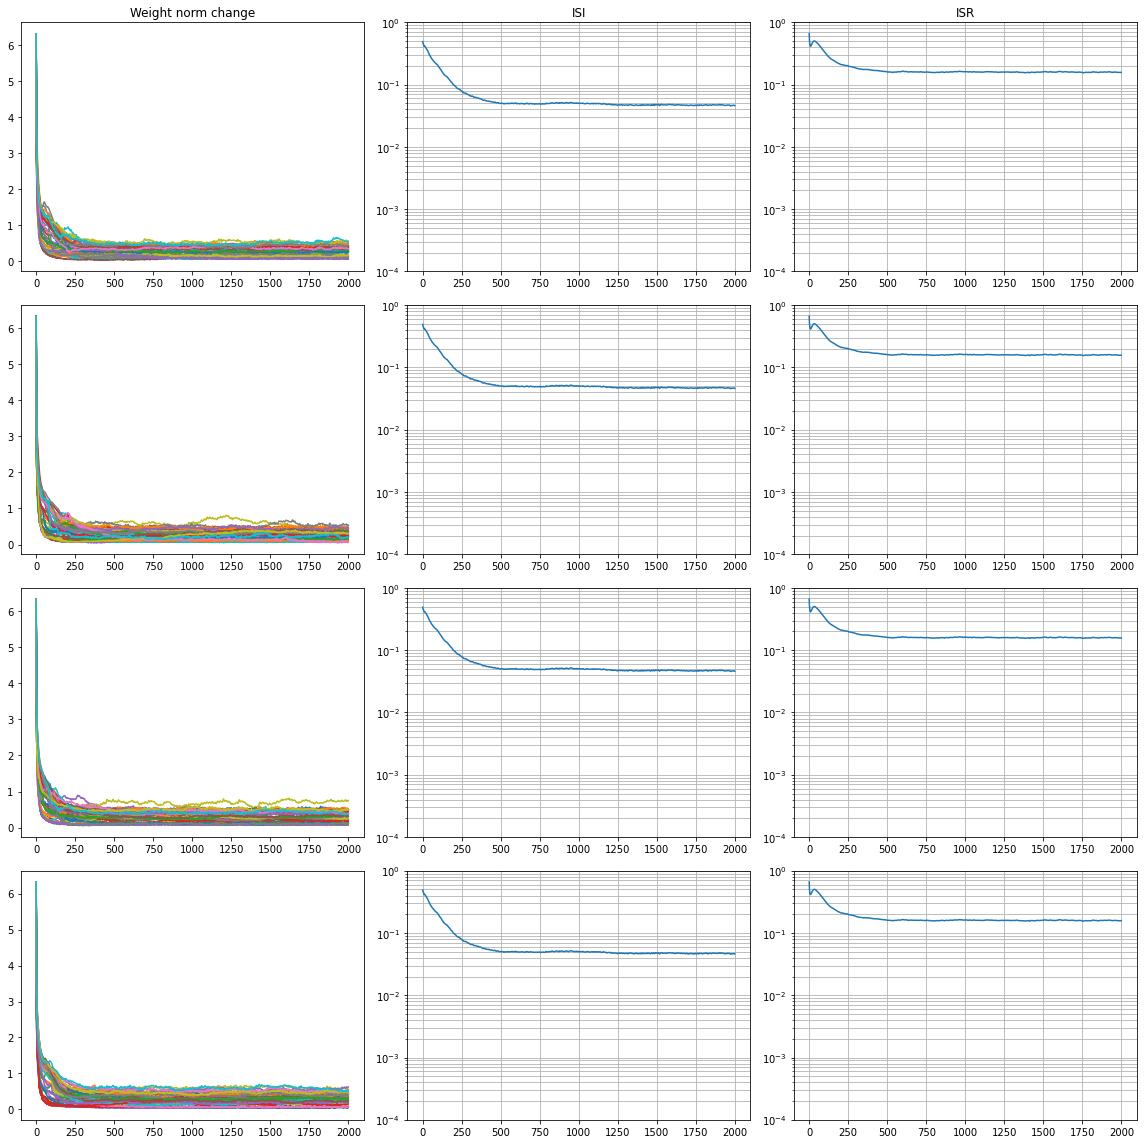

In [526]:
fig, axes = plt.subplots(K, 3, figsize=(16, 4 * K))

for k in range(K):
    values = (delta_history[k].T, ISI_history, ISR_history)
    for col in range(3):
        axes[k, col].plot(values[col])
        if col != 0:
            axes[k, col].set_ylim((1e-4, 1))
            axes[k, col].set_yscale("log")
            axes[k, col].grid(which="both")

axes[0, 0].set_title("Weight norm change")
axes[0, 1].set_title("ISI")
axes[0, 2].set_title("ISR")

plt.tight_layout()



In [506]:
SSS=W.copy()
W, delta_history, ISI_history, ISR_history = IVA_GV_INC(X, A=A, epochs=1000, lr=.05, sanity_check=False)


100%|███████████████████████████████████████| 1000/1000 [03:45<00:00,  4.43it/s]


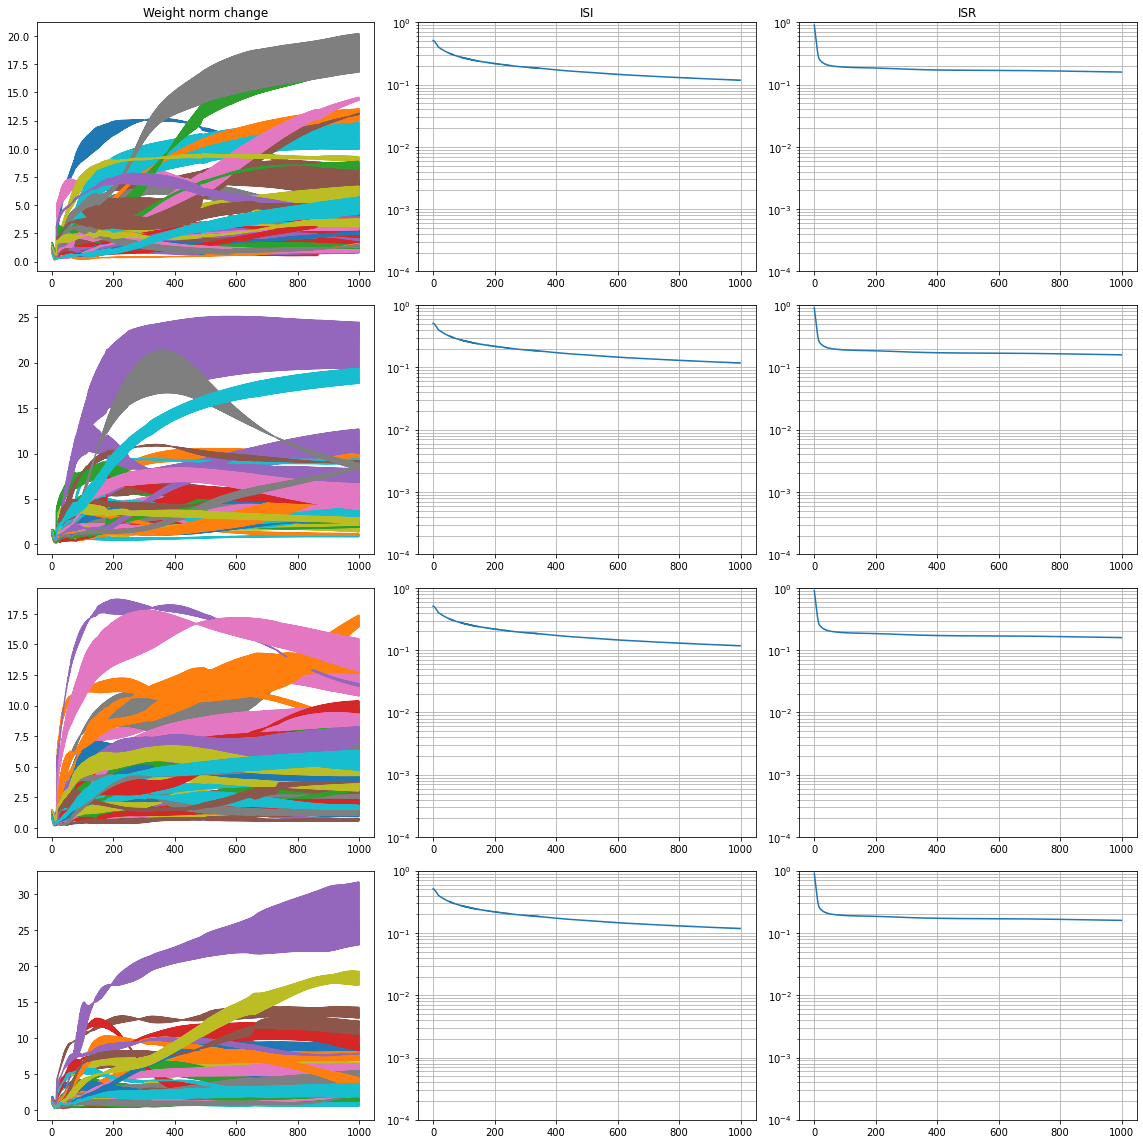

In [507]:
fig, axes = plt.subplots(K, 3, figsize=(16, 4 * K))

for k in range(K):
    values = (delta_history[k].T, ISI_history, ISR_history)
    for col in range(3):
        axes[k, col].plot(values[col])
        if col != 0:
            axes[k, col].set_ylim((1e-4, 1))
            axes[k, col].set_yscale("log")
            axes[k, col].grid(which="both")

axes[0, 0].set_title("Weight norm change")
axes[0, 1].set_title("ISI")
axes[0, 2].set_title("ISR")

plt.tight_layout()

# W, delta_history, ISI_history, ISR_history = IVA_GV(X, A=A, epochs=1000, lr=.01, sanity_check=False)
# W, delta_history, ISI_history, ISR_history = IVA_GV(X, A=A, epochs=2000, lr=.1, sanity_check=False)


In [ ]:
# W = IVA_GN(X, A=A, epochs=100, lr=1e-2)

for k in range(K):
    a = W[k] @ X[k]
    print(W[k] @ A[k])
    plt.title("W_k={} @ A_k={}".format(k, k))
    plt.imshow(a @ a.T / N)
    plt.show()

[[ 3.95528680e-02 -6.71064545e-01  4.73127500e-01  8.65801133e-01]
 [-4.22952265e-01  1.57487686e-03  4.56503312e-05 -1.13376860e-03]
 [-1.53506332e-01 -6.06721706e-01  5.55106791e-03 -3.60506467e-01]
 [ 1.92796716e-01  2.76539403e-01 -7.64647089e-01  9.82437245e-02]]


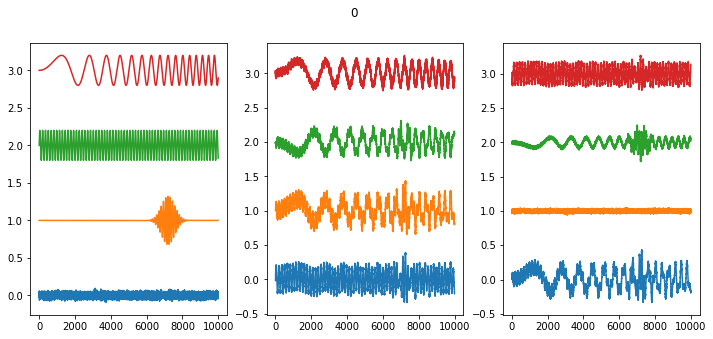

[[-2.41107900e-01  4.32079728e-01 -2.98818830e-01 -5.43178321e-01]
 [ 2.05691543e-01 -4.45224286e-04 -1.04866988e-04  1.20742648e-03]
 [ 7.78069743e-02  3.93615918e-01 -5.88584626e-03  2.31979593e-01]
 [-1.37898743e-01 -3.13718633e-01  8.32543142e-01 -1.10799967e-01]]


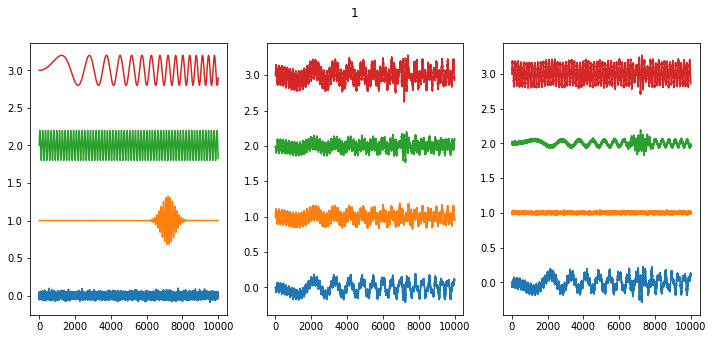

[[ 9.47761322e-02  3.03863422e-02 -2.47318825e-02 -4.21512536e-02]
 [-9.36810146e-01  5.22833780e-03  1.16418886e-03 -1.40518516e-04]
 [-7.75179298e-02 -6.69517023e-01  1.05486863e-02 -4.11398352e-01]
 [-4.73124247e-02  3.50883697e-01 -9.23497029e-01  1.23754074e-01]]


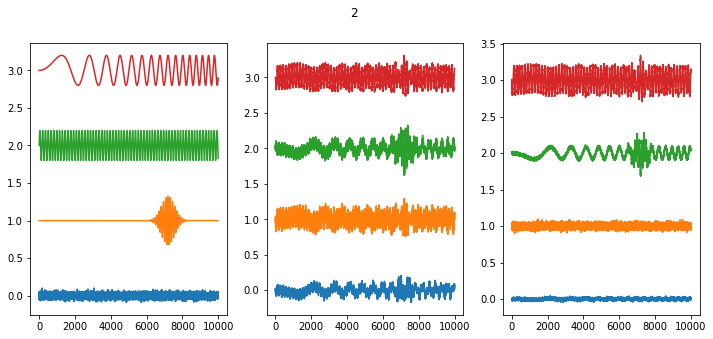

[[-9.13965065e-02  7.70046303e-01 -5.32036721e-01 -9.73878626e-01]
 [-7.07790542e-01 -2.86697581e-03 -9.11924898e-04 -7.16575144e-04]
 [ 3.05476070e-02 -1.50219204e+00  1.59030118e-02 -8.86454795e-01]
 [ 4.78873746e-02  4.28546743e-01 -1.17180900e+00  1.55526616e-01]]


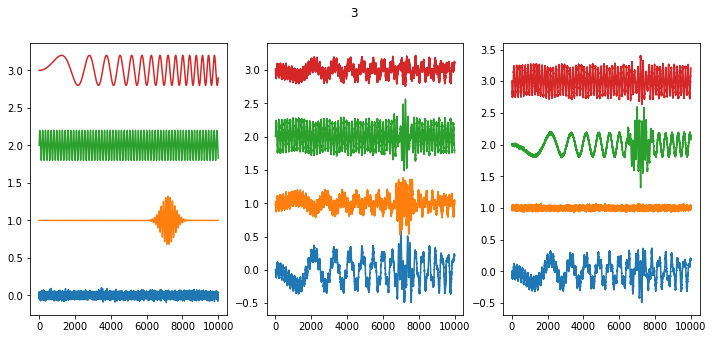

In [67]:
# W = IVA_GN(X, A=A, epochs=100, lr=1e-2)

for k in range(K):
    a = W[k] @ X[k]
    print(W[k] @ A[k])
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    plt.suptitle(str(k))
    axes[0].plot(S[k].T + np.arange(M).reshape(1, -1))
    axes[1].plot(X[k].T + np.arange(M).reshape(1, -1))
    axes[2].plot(a.T + np.arange(M).reshape(1, -1))
    plt.show()

In [52]:
np.log10(ISI(W, A)), np.log10(ISR(W, A))

(-0.32445132158836615, -0.12327371805400958)

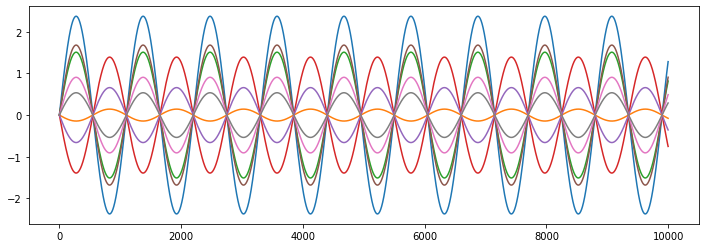

In [45]:
plt.figure(figsize=(12, 4))
plt.plot(X[0].T)

In [127]:
seed = 1
np.random.seed(seed)
SCVs = list()
for m in range(M):
    cov = np.random.normal(size=(K, K))
    cov = cov @ cov.T
    SCV = np.random.multivariate_normal(np.zeros(K), cov, size=(N)).T
    SCVs.append(SCV)
SCVs = np.stack(SCVs)
W = np.random.normal(0, 1, size=(K, M, M))
W_opt = np.stack([np.linalg.inv(w) for w in W])
S = SCVs.transpose(1, 0, 2)
X = np.stack([w @ x for w, x in zip(W, X)])
# Sources = np.stack([whitening_multivar_signal(Source) for Source in Sources])
# True_Weights = np.random.normal(0, 1, size=(K, M, M))
# Obs = np.stack([True_Weights[k] @ Sources[k] for k in range(K)])
X.shape

(10, 8, 10000)

(<matplotlib.image.AxesImage at 0x7eff182089a0>, (10, 10), 10, 8)

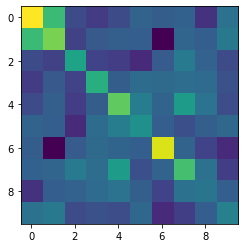

In [132]:
plt.imshow(S[:, 0] @ S[:, 0].T), (S[:, 0] @ S[:, 0].T).shape, K, M

(<matplotlib.image.AxesImage at 0x7eff182e7ca0>, (8, 8), 10, 8)

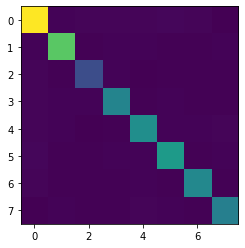

In [136]:
plt.imshow(S[0] @ S[0].T), (S[0] @ S[0].T).shape, K, M

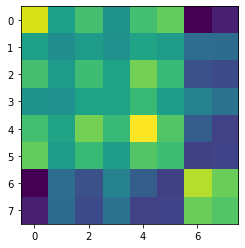

In [137]:
plt.imshow(X[0] @ X[0].T)

(<matplotlib.image.AxesImage at 0x7eff182a6ca0>, (10, 10), 10, 8)

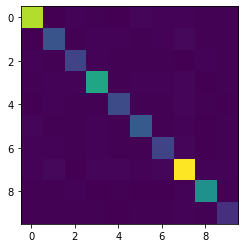

In [135]:
plt.imshow(X[:, 0] @ X[:, 0].T), (X[:, 0] @ X[:, 0].T).shape, K, M

(<matplotlib.image.AxesImage at 0x7eff1892fb20>, (10, 10), 10, 8)

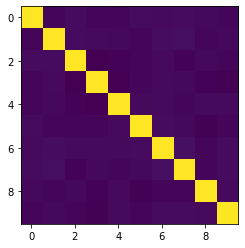

In [129]:
Z = np.stack([whitening_multivar_matrix(x) @ x for x in X])
plt.imshow(Z[:, 0] @ Z[:, 0].T), (Z[:, 0] @ Z[:, 0].T).shape, K, M

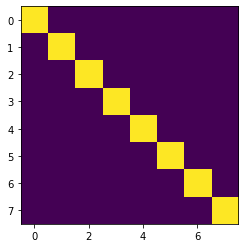

In [81]:
plt.imshow(np.cov(whitening_multivar_matrix(X[0]) @ X[0]))

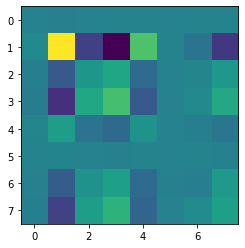

In [131]:
plt.imshow(whitening_multivar_matrix(X[1]) @ W[1])

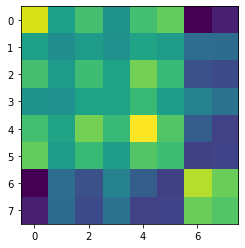

In [89]:
plt.imshow(np.cov(W_opt[0] @ X[0]))

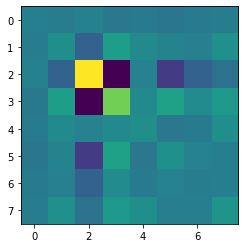

In [90]:
plt.imshow(np.cov(W_opt[1] @ X[1]))

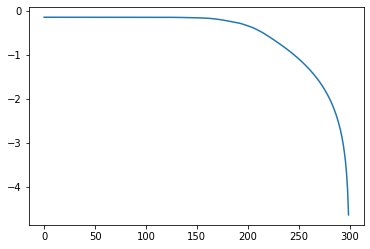

In [78]:

hist = list()
n = 300
for i in range(300):
    hist.append(
        ISI(W * ((n - i) / n) ** 2 + W_opt * (i / n) ** 2, A)
    )
plt.plot(np.log10(hist))

In [ ]:
K = 10
M = 3
N = 1000
cov = np.random.normal(size=(M, M))
cov = cov @ cov.T
Sources = np.random.multivariate_normal(np.zeros(M), cov, size=(K, N)).transpose(0, 2, 1)
Sources = np.stack([whitening(Source) for Source in Sources])
True_Weights = np.random.rand(K, M, M)
Obs = np.stack([True_Weights[k] @ Sources[k] for k in range(K)])

W, delta_history, ISI_history, ISR_history = IVA_GV(Obs, A=True_Weights, epochs=100, lr=1e-2)

fig, axes = plt.subplots(K, 3, figsize=(16, 4 * K))

for k in range(K):
    axes[k, 0].plot(np.log10(delta_history[k]).T)
    axes[k, 1].plot(np.log10(ISI_history))
    axes[k, 2].plot(np.log10(ISR_history))


In [ ]:
from tqdm import tqdm

def get_R(z):
    K, M, N = z.shape
    R = np.empty((K, K, M, M))
    # for every SCV [s_m^1, ..., s_m^K] 
    for k1, k2 in product(range(K), range(K)):
        R[k1, k2] = z[k1] @ z[k2].T / N
    return R


# W = init_W(K, M)

Z = X
cov = np.random.normal(size=(M, M))
cov = cov @ cov.T
S_ = np.random.multivariate_normal(np.zeros(M), cov, size=(K, 1000)).transpose(0, 2, 1)

# W = np.stack([np.eye(M) + np.random.rand(M, M)/10 for k in range(K)])
W = np.stack([np.eye(M) for k in range(K)])
W = np.random.rand(K, M, M)

Z = np.stack([W[k] @ S_[k] for k in range(K)])

epochs = 400
lr = 1e-2
delta_history = np.empty((K, M, epochs))
ISI_history = np.empty(epochs)
ISR_history = np.empty(epochs)

R = get_R(Z) # K x K
sigma_0 = np.stack([Z[:, n] for n in range(M)])

for i in tqdm(range(epochs)):

    Y = np.stack([W[k] @ Z[k] for k in range(K)])
    H = np.stack([recursive_h(W[k]) for k in range(K)]) # K x M x M x 1
        
    sigma_inv = np.empty((M, K, K))
    
    for n in range(M):
        sigma_inv[n] = np.linalg.inv(Y[:, n] @ Y[:, n].T / N)

    for k in range(K):
        e = np.zeros((K, 1))
        e[k] = 1
    
        for n in range(M):
            delta = Z[k] @ Y[:, n].T @ sigma_inv[n] @ e / N
            delta -= H[k, n] / (H[k, n].T @ W[k, n])
            # E[x[k] @ y[n].T] @ sigma_n ^⁻1 @ ek
            delta = delta.flatten()
#             delta = (Z[k]).mean(axis=1, keepdims=True).T

            w_n_new = W[k, n] - lr * delta
            w_n_new = w_n_new / norm(w_n_new, 2)
            delta_history[k, n, i] = norm(W[k, n] - w_n_new)
            W[k, n] = w_n_new
            
    ISI_history[i] = (ISI(W, A))
    ISR_history[i] = ISR(
        reorder(W, A, ISR),
        A
    )
# 

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(ISI_history)
plt.show()

In [ ]:
for k in range(K):
    plt.figure(figsize=(12, 4))
    plt.plot(np.log10(delta_history[k]).T)
    plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(ISR_history)
plt.show()

In [ ]:
for k in range(K):
    plt.figure(figsize=(4, 4))
    plt.imshow(W[k])
               
               

In [ ]:
for k in range(K):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#     axes[0].plot((Z[k]).T+ 20*np.arange(M).reshape(1, -1))
#     axes[1].plot((W[k] @ Z[k]).T+ 20*np.arange(M).reshape(1, -1))
    axes[0].plot((Z[k]).T+ np.arange(M).reshape(1, -1))
    axes[1].plot((W[k] @ Z[k]).T+ np.arange(M).reshape(1, -1))
    plt.tight_layout()
    axes[0].set_title("Original")
    axes[1].set_title("Filtered")
    
    plt.show()

In [ ]:
from sklearn.decomposition import FastICA

fica = FastICA(n_components=M)
for k in range(K):
    y = fica.fit_transform(X[k].T)
    plt.figure(figsize=(12, 5))
    plt.plot(y + .25 * np.array([1, 2, 3, 4, 5]).reshape(1, -1))

In [ ]:
from pyiva.iva_laplace import iva_laplace
W = iva_laplace(Z)

In [ ]:
for k in range(K):
    plt.figure(figsize=(12, 4))
    plt.plot((W[k] @ S[k]).T+ 20 * np.arange(M).reshape(1, -1))
    plt.show()

In [ ]:
plt.imshow(W[0])